### Understanding LangGraph 
LangGraph is a special LangChain-built libray that focuses on bulding intelligent AI Agent use graph. le, agentic
state machines

We need these prerequisite libraies to run a graph visualization libray (pygraphviz). we will use this libray during 
this notebook to understand the structure of our graphs but is not required to use langgraph.


In [3]:
# If you base on Mac os system
# !brew install python3 graphviz pkg-config

# If you base on ubuntu 
# apt-get install python3-dev graphviz libgraphviz-dev pkg-config

### Initialization model

In [2]:
# Install pygraphviz for visualizing
export CFLAGS="-I/opt/homebrew/Cellar/graphviz/12.2.0/include"
export LDFLAGS="-L/opt/homebrew/Cellar/graphviz/12.2.0/lib"
#pip install pygraphviz
#!pip install -qU pygraphviz==1.12

SyntaxError: invalid syntax (2185087212.py, line 2)

In [15]:
import vertexai
import os
import IPython
# load google access config file
credential_path="/Users/gongbiao/Code/vertex-ai/config/google_access_token_cp.json"
if os.path.exists(credential_path):
    print(f"the config load success")
else:
    print("config file does'not exists!")
    
# init vertex ai
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

the config load success


### Optional proxy setting

In [1]:
# [Optinal] set proxy
import os
proxy = "http://127.0.0.1:8889"
os.environ["HTTP_PROXY"] = proxy
os.environ["HTTPS_PROXY"] = proxy
os.environ["http_proxy"] = proxy
os.environ["https_proxy"] = proxy

### Graph State
We will define a custom graph state to support our agent-oriented decision making. In this we will define:
- our user `input` (ie the most recent mesage from the user)
- `agent_out` which is used by the graph (and our final output) to consume/output agent outputs
- `intermediate_steps` which is a list maintained over our graph runtime to keep track of the results of previous

During each step in our graph we will be able to add to,modify, or extract these values from our state object.

In [ ]:
### Import LLM model

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator

class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]


### Emulate Search 
To test a RAG-like agent we'll provide a tool that provide information as we would expect a search tool in a RAG agent to do.

In [3]:
ehi_information = """Title: EHI: End-to-end Learning of Hierarchical Index for
Efficient Dense Retrieval
Summary: Dense embedding-based retrieval is now the industry
standard for semantic search and ranking problems, like obtaining relevant web
documents for a given query. Such techniques use a two-stage process: (a)
contrastive learning to train a dual encoder to embed both the query and
documents and (b) approximate nearest neighbor search (ANNS) for finding similar
documents for a given query. These two stages are disjoint; the learned
embeddings might be ill-suited for the ANNS method and vice-versa, leading to
suboptimal performance. In this work, we propose End-to-end Hierarchical
Indexing -- EHI -- that jointly learns both the embeddings and the ANNS
structure to optimize retrieval performance. EHI uses a standard dual encoder
model for embedding queries and documents while learning an inverted file index
(IVF) style tree structure for efficient ANNS. To ensure stable and efficient
learning of discrete tree-based ANNS structure, EHI introduces the notion of
dense path embedding that captures the position of a query/document in the tree.
We demonstrate the effectiveness of EHI on several benchmarks, including
de-facto industry standard MS MARCO (Dev set and TREC DL19) datasets. For
example, with the same compute budget, EHI outperforms state-of-the-art (SOTA)
in by 0.6% (MRR@10) on MS MARCO dev set and by 4.2% (nDCG@10) on TREC DL19
benchmarks.
Author(s): Ramnath Kumar, Anshul Mittal, Nilesh Gupta, Aditya Kusupati,
Inderjit Dhillon, Prateek Jain
Source: https://arxiv.org/pdf/2310.08891.pdf"""

### Custom Tools
We wil define two tools for this agent, a `search` tool (which emulates our RAG component) and a `final_answer` tool -- which is 
providers output in a sepcific format. ie:
```json
{
    "answer": "<LLM generated answer here>",
    "source": "<LLM generated citation here>"
}
```

We define both using the `@tool` decorator from LangChain.

In [5]:
from langchain_core.tools import tool

@tool("search")
def search_tool(query: str):
    """Searches for information on the topic of artificial intelligence (AI).
    Cannot be used to research any other topics. Search query must be provided
    in natural language and be verbose."""
    # this is a "RAG" emulator
    return ehi_information

@tool("final_answer")
def final_answer_tool(
    answer: str,
    source: str
):
    """Returns a natural language response to the user in `answer`, and a
    `source` which provides citations for where this information came from.
    """
    return ""

These tools will be triggered via OpenAI Tools (ie function calling). The LLM will be provided information on the schema (ie structure) of the function to be called, like that which we can see here:

In [6]:
search_tool

StructuredTool(name='search', description='Searches for information on the topic of artificial intelligence (AI).\n    Cannot be used to research any other topics. Search query must be provided\n    in natural language and be verbose.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search_tool at 0x1203dc8b0>)

### Initalize Agent

In [ ]:
import os
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_google_vertexai import ChatVertexAI
from langchain_community.llms.moonshot import Moonshot
from langchain_openai import ChatOpenAI

# load google access config file
credential_path="/Users/gongbiao/Code/vertex-ai/config/google_access_token_cp.json"
if os.path.exists(credential_path):
    print(f"the config load success")
else:
    print("config file does'not exists!")
    
# init vertex ai
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

# Cannot use vertex ai
## llm = ChatVertexAI(model_name="gemini-1.5-flash-002",temperature=0)
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or api_key
# base url
os.environ["OPENAI_API_BASE"] = os.getenv("OPENAI_API_BASE") or "https://api.moonshot.cn/v1"
llm = ChatOpenAI(model_name="moonshot-v1-8k",temperature=0)

prompt = hub.pull("hwchase17/openai-functions-agent")


query_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=[final_answer_tool, search_tool],
    prompt=prompt
)
     

the config load success


/opt/homebrew/anaconda3/lib/python3.10/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Test the agent quickly to confirm it is functional:

In [12]:
# To use chat vertex ai model
inputs = {
    "input": "what are EHI embeddings?",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
print(agent_out)

[ToolAgentAction(tool='search', tool_input={'query': 'EHI embeddings'}, log="\nInvoking: `search` with `{'query': 'EHI embeddings'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'search:0', 'function': {'arguments': '{\n  "query": "EHI embeddings"\n}', 'name': 'search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 147, 'total_tokens': 169, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'moonshot-v1-8k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6a08b3a4-1ec6-4477-80dd-102cf3368088-0', tool_calls=[{'name': 'search', 'args': {'query': 'EHI embeddings'}, 'id': 'search:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 147, 'output_tokens': 22, 'total_tokens': 169, 'input_token_details': {}, 'output_token_details': {}})], tool_call_id='search:0')]


In [18]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'search:0',
 'function': {'arguments': '{\n  "query": "EHI embeddings"\n}',
  'name': 'search'},
 'type': 'function',
 'index': 0}

The agent won't perform the function calls themselvs, that is up to us and we will handle it in downstream actions through out agent
graph.

The infromation provided by `agent_out` will be used to decide whether we move to the `search` or `END` nodes of our graph. We'll 
also add a `error` handler node in case our agent fails to produce the output we need.

### Define Nodes for Graph

In [53]:
from langchain_core.agents import AgentFinish
import json

def run_query_agent(state: list):
    print("> run_query_agent")
    agent_out = query_agent_runnable.invoke(state)
    return {"agent_out": agent_out}

def execute_search(state: list):
    print("> execute_serach")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    out = search_tool.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    return {"intermediate_steps": [{"search": str(out)}]}

def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    else:
        return "error"
    
# finally, we will have a single LLM call that MUST use the final_anser structure
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")

# This forced final_answer LLM call will be used to structure output from our
# RAG endpoint
def rag_final_answer(state: list):
    print("> final_answer")
    query = state.get("input", "")
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    context provided.

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our query_agent
def handle_error(state: list):
    print("> handle_error")
    query = state.get("input", "")
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

### Define Graph
Our graph is constructed of `ndoes` and `edges`. A node represents a function (one of those we just defined above) whereas an edge
allows us to travel from one node to another.

Let's start by initializing our graph using our `AgentState` object and adding our first set of nodes and the graph entry point
(ie where the graph begins once called).

In [54]:
from langgraph.graph import StateGraph
graph  = StateGraph(AgentState)

# We have four nodes that will consume our agent state and modify
# our agent state based on some interanl process
graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

# our grpah will always begin with the query agent
graph.set_entry_point("query_agent")


In addition to our nodes we have our "one-way" edges — that is, once node X is called the state must continue to node Y as defined by these edges. We define these using:

`graph.add_edge(X, Y)`
If X or Y are defined nodes in our graph we pass the name of that node in string format. So, if we want to add an edge that navigates from our "search" node to our "rag_final_answer" node, we do:

`graph.add_edge("search", "rag_final_answer")`
We will also have an end node in our graph — we have not defined this end node as it is imported as a specific graph object END. To use this, we must add edges between our final nodes and the END object, like so:

`graph.add_edge("rag_final_answer", END)`
When the END node is called, our graph completes.

In [55]:

from langgraph.graph import Graph, END

# create a graph object
graph = Graph()

# 添加节点的方式保持不变
graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

graph.set_entry_point("query_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    "query_agent",  # 起始节点
    router,  # 路由函数
    {  # 边的映射
        "search": "search",
        "error": "error",
        "final_answer": END
    }
)

graph.add_edge("search", "rag_final_answer")
graph.add_edge("error", END)
graph.add_edge("rag_final_answer", END)

runable = graph.compile()



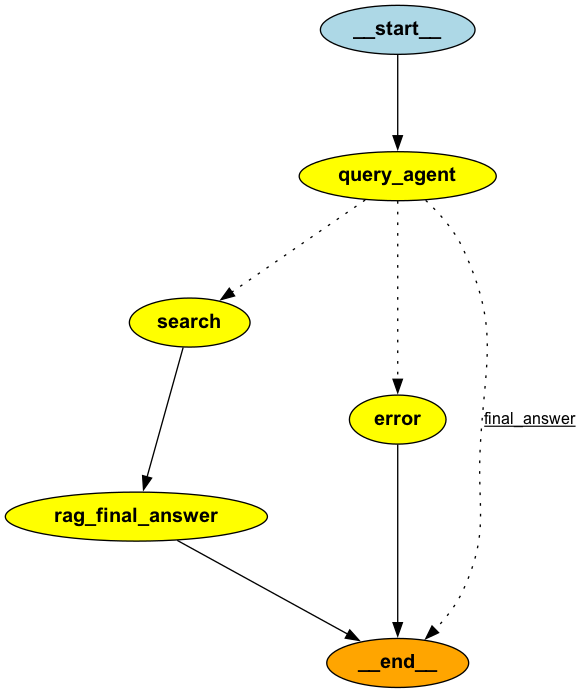

In [56]:
# Visualize the graph
from IPython.display import Image
Image(runable.get_graph().draw_png())

In [58]:
out = runnable.invoke({
    "input": "what is AI?",
    "chat_history": [],
    "intermediate_steps": [],
    "agent_out": None
})

> run_query_agent
> router
> execute_serach
> final_answer


KeyError: 'tool_calls'

### Many be model can not support function call